In [1]:
# Reads and processed data from the 2019 CHAOS challenge in T2SPIR format - https://chaos.grand-challenge.org/Data/
# Data processed per https://arxiv.org/pdf/2002.02255.pdf
# The data will be formatted in tfrecord format similar to https://github.com/cchen-cc/SIFA/

In [2]:
# https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# https://stackoverflow.com/questions/56008683/could-not-create-cudnn-handle-cudnn-status-internal-error
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
import tensorflow as tf

import io_utils as io
import augmentations as aug
import data_utils

import os
import pydicom

import imageio
from PIL import Image

import importlib

In [4]:
chaos_data_dir = "./data/abdomen/raw-data/CHAOS_Train_Sets/Train_Sets/MR/"
processed_data_dir = "./data/abdomen/processed-data/"
train_dir = "mri_chaos_train_tfs/"
val_dir = "mri_chaos_val_tfs/"
train_file_list = processed_data_dir + "mri_chaos_train_list"
val_file_list = processed_data_dir + "mri_chaos_val_list"

In [5]:
# we use the following final mapping for labels
label_ids_abdomen = {"ignore": 0,
    "liver": 1,
    "right_kidney": 2,
    "left_kidney": 3,
    "spleen": 4,
 }

# From CHAOS readme - the ranges for each class
# Liver: 63 (55<<<70)
# Right kidney: 126 (110<<<135)
# Left kidney: 189 (175<<<200)
# Spleen: 252 (240<<<255)

In [6]:
def read_and_process(img_file, label_file):
    # Read img/label files
    # Rescale the image between [0,1] to avoid Image.resize errors
    img = np.asarray(pydicom.dcmread(img_dir + img_file).pixel_array)
    img = img / np.max(img)

    labels = np.asarray(imageio.imread(label_dir + label_file))

    # Parse labels to be between 0-4
    for x in range(labels.shape[0]):
        for y in range(labels.shape[1]):
            if 55 <= labels[x,y] and labels[x,y] <= 70:
                labels[x,y] = 1
            elif 110 <= labels[x,y] and labels[x,y] <= 135:
                labels[x,y] = 2
            elif 175 <= labels[x,y] and labels[x,y] <= 200:
                labels[x,y] = 3
            elif 240 <= labels[x,y] and labels[x,y] <= 255:
                labels[x,y] = 4
            else:
                labels[x,y] = 0

    # Resize image and labels
    img = Image.fromarray(img).resize((256,256), Image.LANCZOS)
    img = np.asarray(img)

    labels = Image.fromarray(labels).resize((256,256), Image.NEAREST)
    labels = np.asarray(labels)
    
    assert 0 <= np.min(labels) and np.max(labels) <= 4
    
    return img, labels

In [7]:
importlib.reload(data_utils)

scans = []
labels3d = []

for subdir in sorted(os.listdir(chaos_data_dir)):
    print(subdir)
    
    curr_dir = chaos_data_dir + subdir + "/T2SPIR/"
    
    img_dir = curr_dir + "DICOM_anon/"
    label_dir = curr_dir + "Ground/"
    
    img_slices = []
    label_slices = []
    
    for img_file in sorted(os.listdir(img_dir)):
        label_file = img_file.rsplit(".")[0] + ".png"
        
        curr_img_slice, curr_label_slice = read_and_process(img_file, label_file)
        
        img_slices.append(curr_img_slice)
        label_slices.append(curr_label_slice)
    
    img_slices = np.asarray(img_slices)
    label_slices = np.asarray(label_slices)
    
    # Make the immages channel last
    img_slices = np.moveaxis(img_slices, 0, -1)
    label_slices = np.moveaxis(label_slices, 0, -1)
    
    # Normalize the images
    print(img_slices.shape, label_slices.shape)
    print(np.min(img_slices), np.max(img_slices))
    print(np.mean(img_slices), np.std(img_slices))
    
    img_slices = data_utils.normalize(img_slices)
    
    print(np.min(img_slices), np.max(img_slices))
    print(np.mean(img_slices), np.std(img_slices))
    print()
    
    # Store all images and labels
    scans.append(np.copy(img_slices))
    labels3d.append(np.copy(label_slices))

1
(256, 256, 36) (256, 256, 36)
0.0 1.0
0.065237485 0.120834455
-0.53989136 3.0
-0.024183158 0.89980215

10
(256, 256, 36) (256, 256, 36)
0.0 1.0
0.05615447 0.10773043
-0.52124983 3.0
-0.02865578 0.8711445

13
(256, 256, 30) (256, 256, 30)
-0.10544666 1.0193764
0.0578508 0.10915983
-1.4959483 3.0
-0.031935308 0.8598738

15
(256, 256, 26) (256, 256, 26)
0.0 1.0
0.080968544 0.13558713
-0.5971699 3.0
-0.025770782 0.89714825

19
(256, 256, 30) (256, 256, 30)
-0.018233098 1.0270134
0.0590033 0.113273814
-0.6818557 3.0
-0.03159018 0.8620835

2
(256, 256, 26) (256, 256, 26)
-0.029549873 1.0299958
0.08160759 0.14076287
-0.789679 3.0
-0.026833799 0.89399225

20
(256, 256, 26) (256, 256, 26)
-0.026097076 1.0282538
0.060872838 0.11422331
-0.7614024 3.0
-0.028309856 0.88080704

21
(256, 256, 31) (256, 256, 31)
0.0 1.0
0.054274376 0.11569151
-0.46913016 3.0
-0.032080814 0.85750186

22
(256, 256, 33) (256, 256, 33)
0.0 1.0
0.06297435 0.11635074
-0.5412458 3.0
-0.029656142 0.8697321

3
(256, 256, 30)

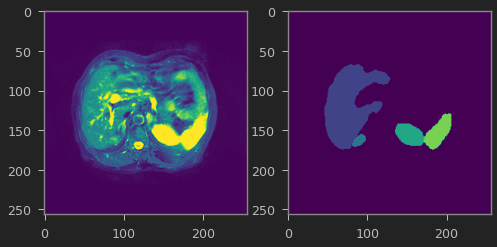

In [8]:
_,ax = plt.subplots(1,2)
ax[0].imshow(scans[6][...,15])
ax[1].imshow(labels3d[6][...,15], vmin=0, vmax=5)
plt.show()

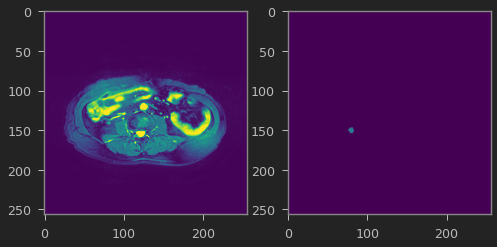

In [9]:
_,ax = plt.subplots(1,2)
ax[0].imshow(scans[6][...,2])
ax[1].imshow(labels3d[6][...,2], vmin=0, vmax=5)
plt.show()

In [11]:
# Split 80% of the scans for training, and 20% for testing

np.random.seed(42)

train_indices = sorted(np.random.choice(range(20), 16, replace=False))
# val_indices = np.asarray(sorted([x for x in range(20) if x not in train_indices]))

scans_train = []
labels3d_train = []
scans_val = []
labels3d_val = []

for idx in range(len(scans)):
    if idx in train_indices:
        scans_train.append(scans[idx])
        labels3d_train.append(labels3d[idx])
    else:
        scans_val.append(scans[idx])
        labels3d_val.append(labels3d[idx])
        
print(len(scans_train), len(scans_val))
print(len(labels3d_train), len(labels3d_val))

16 4
16 4


In [12]:
importlib.reload(aug)

np.random.seed(0)

# The index of each slice
record_index = 0
train_files = []

for (scan,labels) in zip(scans_train, labels3d_train):
    print("Working on a new scan")
    
    # Compute a three channel image via selecting three consecutive slices
    for idx in range(scan.shape[2]):
        X,Y = io.get_consecutive_slices(scan, labels, idx, target_shape=(256,256,3))
            
        to_save = [(X, Y)]
        for times in range(20):
            to_save.append(aug.combined(X,Y))
        
        # Finally, save the images to tfrecord
        for i in range(len(to_save)):
            assert 0 <= np.min(to_save[i][1]) and np.max(to_save[i][1]) <= 4
            
            filename = train_dir + "mri_chaos_slice" + str(record_index) + ".tf"
            train_files.append(filename)
            io.to_tfrecord(to_save[i][0], to_save[i][1], processed_data_dir + filename)
            record_index += 1

Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan


In [13]:
with open(train_file_list, 'w') as fct_list:
    for item in train_files:
        fct_list.write("%s\n" % item)

In [14]:
im,la = io.sample_batch(processed_data_dir, \
                     train_files, \
                     data_type='mr', \
                     batch_size=30)

In [15]:
importlib.reload(aug)

np.random.seed(0)

# The index of each slice
record_index = 0
val_files = []

for (scan,labels) in zip(scans_val, labels3d_val):
    print("Working on a new scan")
    
    # Compute a three channel image via selecting three consecutive slices
    for idx in range(scan.shape[2]):
        X,Y = io.get_consecutive_slices(scan, labels, idx, target_shape=(256,256,3))
            
        to_save = [(X, Y)]
        for times in range(20):
            to_save.append(aug.combined(X,Y))
        
        # Finally, save the images to tfrecord
        for i in range(len(to_save)):
            assert 0 <= np.min(to_save[i][1]) and np.max(to_save[i][1]) <= 4
            
            filename = val_dir + "mri_chaos_slice" + str(record_index) + ".tf"
            val_files.append(filename)
            io.to_tfrecord(to_save[i][0], to_save[i][1], processed_data_dir + filename)
            record_index += 1

Working on a new scan
Working on a new scan
Working on a new scan
Working on a new scan


In [16]:
with open(val_file_list, 'w') as fct_list:
    for item in val_files:
        fct_list.write("%s\n" % item)

In [17]:
im,la = io.sample_batch(processed_data_dir, \
                     val_files, \
                     data_type='mr', \
                     batch_size=30)

In [18]:
print("Ok!")

Ok!
